<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/2022_10_07_%EA%B3%BC%EC%A0%9C%20%ED%8C%8C%EC%9D%B4%EC%8D%AC%20%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%20%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>**06. 사이킷런으로 수행하는 타이타닉 생존자 예측**

타이타닉 데이터로 생존자 예측을 수행해보자.
<br/>맷플롯립과 시본을 이용해 차트와 그래프도 함께 보면서 분석을 진행해보자

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df=pd.read_csv('titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
#칼럼 타입 확인
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


판다스의 objcet 타입은 string 타입으로 봐도 무방하다.
<br/>사이킷런은 null 값을 허용하지 않으므로 이 값을 어떻게 처리할지 결정해야한다. fillna() 함수로 간단하게 평균 또는 고정 값으로 변경한다.

In [4]:
#age는 평균으로, 나머지는 'N' 값으로 변경한다.
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 개수 ', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 개수  0


In [5]:
#문자열 피처 Sex, Cabin, Embarked의 값 분류를 살펴보자
print('Sex 값 분포 :\n', titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 :\n', titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 :\n', titanic_df['Embarked'].value_counts())

Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 :
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


Cabin의 경우 속성값이 제대로 정리되지 않음. 이 피처에서는 선실 등급을 나타내는 맨 첫번째 알파벳이 중요해 보인다. 앞 문자만 추출하자.

In [6]:
titanic_df['Cabin']=titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


* str 넣는 것 잊지 말기

데이터를 먼저 탐색해보자. 어떤 유형의 승객이 생존 확률이 높은가?

In [7]:
#성별
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

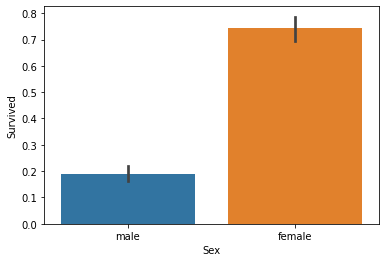

In [8]:
sns.barplot(x='Sex', y='Survived', data=titanic_df)

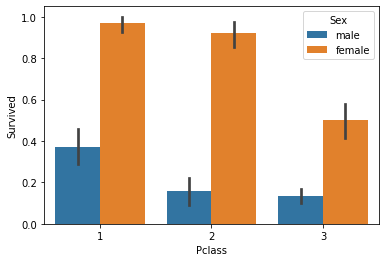

In [9]:
#부자와 가난한 사람 by 객실등급별 성별
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

In [13]:
#나이
#범위별로 분류해 카테고리 값을 할당하자

#입력 age에 따라 구분 값을 반환하는 함수 설정. DataFrame의 apply lambda 식에 사용.
def get_category(age):
  cat=''
  if age<=-1: cat='Unknown'
  elif age<=5: cat='Baby'
  elif age<=12: cat='Child'
  elif age<=18: cat='Teenager'
  elif age<=25: cat='Student'
  elif age<=35: cat='Young Adult'
  elif age<=60: cat='Adult'
  else : cat='Elderly'

  return cat

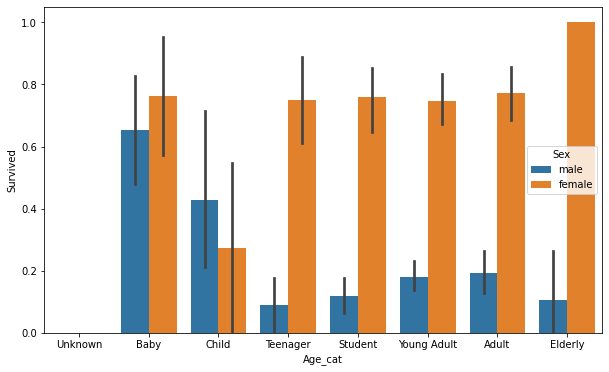

In [14]:
#막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))

#x축의 값을 순차적으로 표시하기 위한 설정
group_names=['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

#lambda 식에 위에서 생성한 get_category() 함수를 반환값으로지정.
#get_category(X)는 입력값으로 'Age' 칼럼 값을 받아서 해당하는 cat 반환
titanic_df['Age_cat']=titanic_df['Age'].apply(lambda x: get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

세 피처 다 어느정도 생존을 좌우하는 피처임을 확인.
<br/>이제 학습을 위해 문자열 카테고리 피처를 숫자형으로 변환하자. 인코딩은 사이킷런의 LabelEncoder 클래스를 이용해 레이블 인코딩을 적용. 사이킷런의 전처리 모듈의 대부분 인코딩 API는 사이킷런의 기본 프레임워크인 fit(), transform()으로 데이터를 변환. 여러 칼럼을 encode_features() 함수를 새로 생성해 한 번에 변환하도록 하자.

In [15]:
from sklearn import preprocessing

def encode_features(dataDF):
  features=['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le=preprocessing.LabelEncoder()
    le=le.fit(dataDF[feature])
    dataDF[feature]=le.transform(dataDF[feature])

  return dataDF

titanic_df=encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3
